In [1]:
import polars as pl

In [2]:
## Load tranquillyzer's valid and invalid annotations

tranquilizer_A375_HYB_invalid_annots = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/A375_10mil/HYB/annotations_invalid.parquet", columns = ["ReadName", "read_length", "reason"])
tranquilizer_A375_HYB_valid_annots = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/A375_10mil/HYB/annotations_valid.parquet", columns = ["ReadName", "read_length", "reason"])
tranquilizer_A375_CRF_invalid_annots = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/A375_10mil/CRF/annotations_invalid.parquet", columns = ["ReadName", "read_length", "reason"])
tranquilizer_A375_CRF_valid_annots = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/A375_10mil/CRF/annotations_valid.parquet", columns = ["ReadName", "read_length", "reason"])


In [3]:

tranquilizer_A375_CRF_combined = pl.concat([tranquilizer_A375_CRF_valid_annots, 
                                            tranquilizer_A375_CRF_invalid_annots], 
                                            how="vertical")

print(tranquilizer_A375_HYB_invalid_annots.shape)
print(tranquilizer_A375_HYB_valid_annots.shape)
print(tranquilizer_A375_CRF_invalid_annots.shape)
print(tranquilizer_A375_CRF_valid_annots.shape)
print(tranquilizer_A375_CRF_combined.shape)


(1813749, 3)
(8186114, 3)
(1875172, 3)
(8124828, 3)
(10000000, 3)


/tmp/ipykernel_3209667/1485340157.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y/1e6:.2f}" for y in yticks])


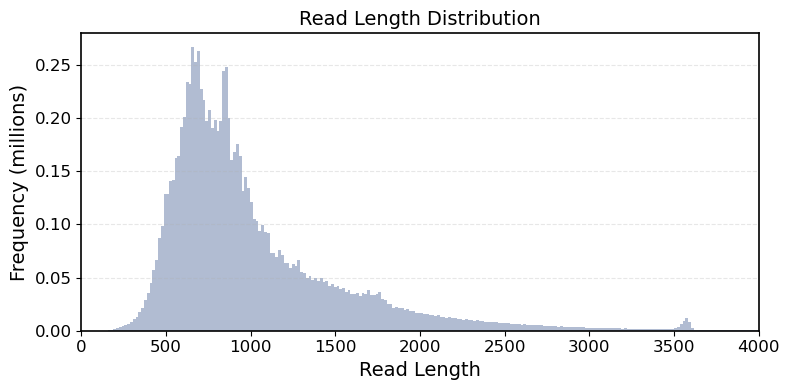

In [4]:
## Summarize the data

## What is the read-length distribution?

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

read_lengths = tranquilizer_A375_CRF_valid_annots["read_length"].to_list() + tranquilizer_A375_CRF_invalid_annots["read_length"].to_list()
read_lengths = np.array(read_lengths)

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(read_lengths, bins=25000, 
             color='#97a6c4', edgecolor='black', 
             stat='count')

yticks = ax.get_yticks()
ax.set_yticklabels([f"{y/1e6:.2f}" for y in yticks])

# Customize plot
ax.set_title("Read Length Distribution", fontsize=14)
ax.set_xlabel("Read Length", fontsize=14)
ax.set_ylabel("Frequency (millions)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.set_xlim(0, 4000)

# Add black frame around the entire plot area
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/read_length_distribution.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/read_length_distribution.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/read_length_distribution.pdf", bbox_inches='tight')

plt.show()


In [ ]:
median_read_length = np.median(read_lengths)
mean_read_length = np.mean(read_lengths)

print(f'Median read length: {median_read_length}')
print(f'Mean read length: {mean_read_length}')

Median read length: 855.0
Mean read length: 1028.5513437


In [5]:
## Major categories of artifacts 

pl.Config.set_tbl_rows(50)
pl.Config.set_fmt_str_lengths(100)

all_artifact_counts = tranquilizer_A375_CRF_invalid_annots\
    .group_by("reason").agg(pl.len().alias("count"))\
        .sort("count", descending=True)\
            .with_columns((pl.col("count")/len(read_lengths))\
                          .alias("proportion"))

print(all_artifact_counts)

shape: (4_229, 3)
┌────────────────────────────────────────────────────────────────────────────┬────────┬────────────┐
│ reason                                                                     ┆ count  ┆ proportion │
│ ---                                                                        ┆ ---    ┆ ---        │
│ str                                                                        ┆ u32    ┆ f64        │
╞════════════════════════════════════════════════════════════════════════════╪════════╪════════════╡
│ concatenated reads x2 (+:1, -:1)                                           ┆ 506583 ┆ 0.050658   │
│ concatenated reads x2 (+:2)                                                ┆ 253428 ┆ 0.0253428  │
│ concatenated reads x2 (-:2)                                                ┆ 213339 ┆ 0.0213339  │
│ Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]                           ┆ 114317 ┆ 0.0114317  │
│ Unexpected pattern: [cDNA_3p_cDNA]                                     

In [6]:
tranquilizer_A375_CRF_invalid_annots.filter(pl.col("read_length") > 3000).group_by("reason").agg(pl.len().alias("count"))\
        .sort("count", descending=True)\
            .with_columns((pl.col("count")/pl.col("count").sum())\
                          .alias("proportion")).head()

reason,count,proportion
str,u32,f64
"""Unexpected pattern: [cDNA]""",36385,0.27756
"""concatenated reads x2 (+:1, -:1)""",14668,0.111893
"""concatenated reads x3 (+:2, -:1)""",10837,0.082669
"""concatenated reads x3 (+:1, -:2)""",9975,0.076093
"""concatenated reads x2 (+:2)""",7560,0.057671


In [7]:
## Concatenated reads proportion

total_concatenated_reads = all_artifact_counts.filter(pl.col("reason").str.contains("concatenated reads"))["count"].sum()
total_concatenated_prop = all_artifact_counts.filter(pl.col("reason").str.contains("concatenated reads"))["proportion"].sum()

print(f'Total concatenated reads: {total_concatenated_reads}')
print(f'Total concatenated poportion: {total_concatenated_prop}')

Total concatenated reads: 1317271
Total concatenated poportion: 0.13172709999999996


In [8]:
## missing 3p proportion
 
total_3p_missing_reads = all_artifact_counts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                        .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))["count"].sum()

total_3p_missing_prop = all_artifact_counts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                        .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))["proportion"].sum()

print(f'Total missing 3p reads: {total_3p_missing_reads}')
print(f'Total missing 3p poportion: {total_3p_missing_prop}')

Total missing 3p reads: 167792
Total missing 3p poportion: 0.0167792


In [9]:
## Truncated 5p

total_trunc_5p_reads = all_artifact_counts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_3p_cDNA_polyT_UMI_CBC_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_CBC_UMI_polyT_cDNA_3p_cDNA]"))["count"].sum()

total_trunc_5p_prop = all_artifact_counts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_3p_cDNA_polyT_UMI_CBC_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_CBC_UMI_polyT_cDNA_3p_cDNA]"))["proportion"].sum()

print(f'Total missing 3p reads: {total_trunc_5p_reads}')
print(f'Total missing 3p poportion: {total_trunc_5p_prop}')

Total missing 3p reads: 64788
Total missing 3p poportion: 0.0064788


In [10]:
## hairpin type error

total_hp_type_reads = all_artifact_counts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]")\
                                                        .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                            .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]"))["count"].sum()

total_hp_type_prop = all_artifact_counts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]")\
                                                        .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                            .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]"))["proportion"].sum()

print(f'Total missing 3p reads: {total_hp_type_reads}')
print(f'Total missing 3p poportion: {total_hp_type_prop}')

Total missing 3p reads: 47321
Total missing 3p poportion: 0.0047320999999999995


In [11]:
## Major artifcats summarized

total_artifactual_reads = all_artifact_counts["count"].sum()

major_artifact_types_dict = {"type" : ["concatenated", "mi 3p", "truncated 5p", "hairpin-like"],
                            "total_reads": [total_concatenated_reads, total_3p_missing_reads, total_trunc_5p_reads, total_hp_type_reads],
                            "total_proportion": [total_concatenated_prop, total_3p_missing_prop, total_trunc_5p_prop, total_hp_type_prop],
                            "proportion_of_artifactual_reads": [total_concatenated_reads/total_artifactual_reads, total_3p_missing_reads/total_artifactual_reads, 
                                                      total_trunc_5p_reads/total_artifactual_reads, total_hp_type_reads/total_artifactual_reads]}

major_artifact_types_df = pl.DataFrame(major_artifact_types_dict)
print(major_artifact_types_df)

shape: (4, 4)
┌──────────────┬─────────────┬──────────────────┬─────────────────────────────────┐
│ type         ┆ total_reads ┆ total_proportion ┆ proportion_of_artifactual_reads │
│ ---          ┆ ---         ┆ ---              ┆ ---                             │
│ str          ┆ i64         ┆ f64              ┆ f64                             │
╞══════════════╪═════════════╪══════════════════╪═════════════════════════════════╡
│ concatenated ┆ 1317271     ┆ 0.131727         ┆ 0.70248                         │
│ mi 3p        ┆ 167792      ┆ 0.0167792        ┆ 0.089481                        │
│ truncated 5p ┆ 64788       ┆ 0.0064788        ┆ 0.03455                         │
│ hairpin-like ┆ 47321       ┆ 0.004732         ┆ 0.025236                        │
└──────────────┴─────────────┴──────────────────┴─────────────────────────────────┘


In [12]:
## Distribution of artifact types across read lengths

bins = [(0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),(2500,3000), (3000, " >")]
major_artifacts_prop_w_bins = []

for bin in bins:
    if bin[1] != " >":
        binned_invalid = tranquilizer_A375_CRF_invalid_annots.filter(
            (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
        binned_valid = tranquilizer_A375_CRF_valid_annots.filter(
            (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
        bin_name = str(bin[0]) + '-' + str(bin[1]) + 'bp'
    else:
        binned_invalid = tranquilizer_A375_CRF_invalid_annots.filter((pl.col('read_length') >= bin[0]))
        binned_valid = tranquilizer_A375_CRF_valid_annots.filter(
            (pl.col('read_length') >= bin[0]))
        bin_name = '> ' + str(bin[0]) + "bp" 
                                                             
    bin_artifacts = binned_invalid.group_by("reason").agg(pl.len().alias("count"))\
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("percentage"))\
            .sort("percentage", descending=True)
    
    total_reads = binned_invalid.shape[0] + binned_valid.shape[0]
    total_artifactual_reads = binned_invalid.shape[0]
    total_artifactual_prop = binned_invalid.shape[0]/(total_reads)

    concat_reads = bin_artifacts.filter(pl.col("reason")\
                                        .str.contains("concatenated reads"))["count"].sum()
    concat_prop = concat_reads/total_reads

    mi_3p = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                  .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                    .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))["count"].sum()
    mi_3p_prop = mi_3p/total_reads

    hp_like = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]")\
                                        .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                            .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]"))["count"].sum()
    hp_like_prop = hp_like/total_reads

    trunc_5p = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_3p_cDNA_polyT_UMI_CBC_cDNA]")\
                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_CBC_UMI_polyT_cDNA_3p_cDNA]"))["count"].sum()
    trunc_5p_prop = trunc_5p/total_reads

    cDNA = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA]"))["count"].sum()
    cDNA_prop = cDNA/total_reads
    
    major_artifacts_prop_w_bins.append((bin_name, 
                                        total_reads/1000000, total_artifactual_reads/1000000, total_artifactual_prop, 
                                        mi_3p/1000000, mi_3p_prop, concat_reads/1000000, concat_prop, trunc_5p/1000000, trunc_5p_prop, 
                                        hp_like/1000000, hp_like_prop, cDNA/1000000, cDNA_prop))

major_artifacts_prop_w_bins_df = pl.DataFrame(major_artifacts_prop_w_bins, 
                                        schema=["bin", "total_reads", "total_artifactual_reads", "total_artifactual_prop", 
                                                "mi_3p", "mi_3p_prop", "concat_reads", "concat_prop", "trunc_5p", "trunc_5p_prop", 
                                                "hp_like", "hp_like_prop", "cDNA", "cDNA_prop"], orient="row")
major_artifacts_prop_w_bins_df

bin,total_reads,total_artifactual_reads,total_artifactual_prop,mi_3p,mi_3p_prop,concat_reads,concat_prop,trunc_5p,trunc_5p_prop,hp_like,hp_like_prop,cDNA,cDNA_prop
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0-500bp""",0.625827,0.097492,0.155781,0.043705,0.069836,0.001276,0.002039,0.00577,0.00922,0.004178,0.006676,0.002686,0.004292
"""500-1000bp""",5.81505,0.317955,0.054678,0.08732,0.015016,0.040727,0.007004,0.043118,0.007415,0.023206,0.003991,0.003563,0.000613
"""1000-1500bp""",2.02299,0.467323,0.231006,0.025325,0.012519,0.375569,0.18565,0.01194,0.005902,0.0107,0.005289,0.002167,0.001071
"""1500-2000bp""",0.901751,0.49508,0.549021,0.007688,0.008526,0.462877,0.513309,0.002999,0.003326,0.005134,0.005693,0.001821,0.002019
"""2000-2500bp""",0.340949,0.248085,0.727631,0.002191,0.006426,0.235623,0.69108,0.000663,0.001945,0.002446,0.007174,0.001708,0.00501
"""2500-3000bp""",0.143494,0.118016,0.822446,0.000685,0.004774,0.112107,0.781266,0.000182,0.001268,0.00104,0.007248,0.001766,0.012307
"""> 3000bp""",0.149939,0.131221,0.875163,0.000878,0.005856,0.089092,0.594188,0.000116,0.000774,0.000617,0.004115,0.036389,0.242692


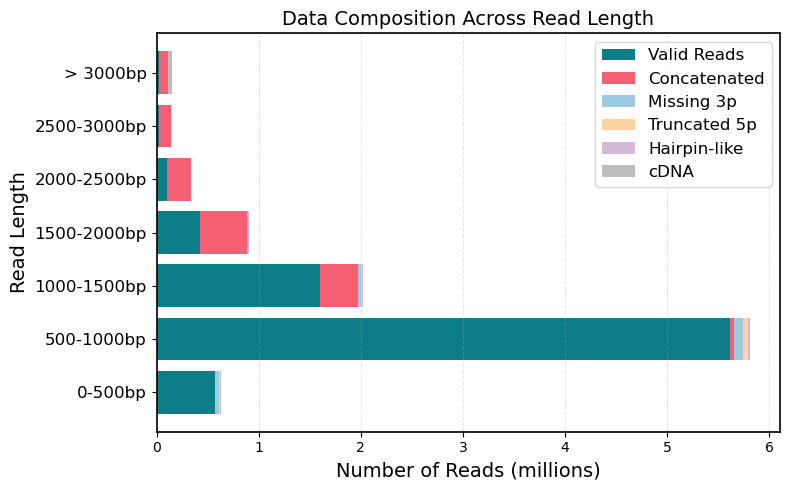

In [13]:
import matplotlib.pyplot as plt

# Convert to pandas
df = major_artifacts_prop_w_bins_df.to_pandas()

# Calculate valid reads
df["valid_reads"] = df["total_reads"] - (
    df["concat_reads"] + df["mi_3p"] + df["trunc_5p"] + df["hp_like"] + df["cDNA"]
)

# Set up components for stacking
bins = df["bin"]
valid = df["valid_reads"]
concat = df["concat_reads"]
mi_3p = df["mi_3p"]
trunc_5p = df["trunc_5p"]
hairpin = df["hp_like"]
cdna = df["cDNA"]

# Plot setup
y_pos = range(len(bins))
bar_width = 0.6
fig, ax = plt.subplots(figsize=(8, 5))


ax.barh(y_pos, valid, color="#0d7d87", label="Valid Reads")          # Soft mint green
ax.barh(y_pos, concat, left=valid, color="#f55f74", label="Concatenated")  # Salmon red
ax.barh(y_pos, mi_3p, left=valid + concat, color="#9ecae1", label="Missing 3p")  # Light blue
ax.barh(y_pos, trunc_5p, left=valid + concat + mi_3p, color="#fdd49e", label="Truncated 5p")  # Peach
ax.barh(y_pos, hairpin, left=valid + concat + mi_3p + trunc_5p, color="#d4b9da", label="Hairpin-like")  # Lavender
ax.barh(y_pos, cdna, left=valid + concat + mi_3p + trunc_5p + hairpin, color="#bdbdbd", label="cDNA")  # Muted gray

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(bins, fontsize=12)
ax.set_xlabel("Number of Reads (millions)", fontsize=14)
ax.set_ylabel("Read Length", fontsize=14)
ax.set_title("Data Composition Across Read Length", fontsize=14)
ax.legend(loc="upper right", fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.grid(axis='y', linestyle='', alpha=0.3)

# Add black border to the entire plot area (panel)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Data_composition_counts.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Data_composition_counts.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Data_composition_counts.pdf", bbox_inches='tight')

plt.show()

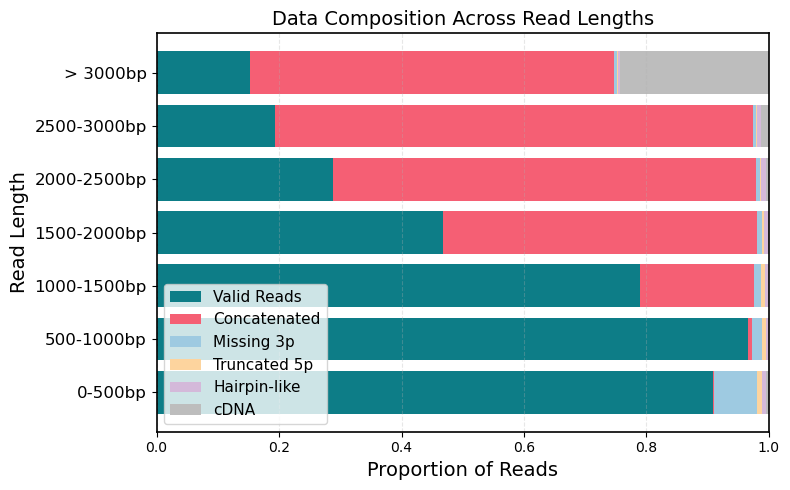

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas
df = major_artifacts_prop_w_bins_df.to_pandas()

# Calculate valid reads
df["valid_reads"] = df["total_reads"] - (
    df["concat_reads"] + df["mi_3p"] + df["trunc_5p"] + df["hp_like"] + df["cDNA"]
)

# Normalize each category by the total reads to get proportions
df["valid_prop"] = df["valid_reads"] / df["total_reads"]
df["concat_prop"] = df["concat_reads"] / df["total_reads"]
df["mi_3p_prop"] = df["mi_3p"] / df["total_reads"]
df["trunc_5p_prop"] = df["trunc_5p"] / df["total_reads"]
df["hairpin_prop"] = df["hp_like"] / df["total_reads"]
df["cdna_prop"] = df["cDNA"] / df["total_reads"]

# Setup for plotting
bins = df["bin"]
valid = df["valid_prop"]
concat = df["concat_prop"]
mi_3p = df["mi_3p_prop"]
trunc_5p = df["trunc_5p_prop"]
hairpin = df["hairpin_prop"]
cdna = df["cdna_prop"]

# Plot setup
y_pos = range(len(bins))
fig, ax = plt.subplots(figsize=(8, 5))

# Stack bar plots
ax.barh(y_pos, valid, color="#0d7d87", label="Valid Reads")
ax.barh(y_pos, concat, left=valid, color="#f55f74", label="Concatenated")
ax.barh(y_pos, mi_3p, left=valid + concat, color="#9ecae1", label="Missing 3p")
ax.barh(y_pos, trunc_5p, left=valid + concat + mi_3p, color="#fdd49e", label="Truncated 5p")
ax.barh(y_pos, hairpin, left=valid + concat + mi_3p + trunc_5p, color="#d4b9da", label="Hairpin-like")
ax.barh(y_pos, cdna, left=valid + concat + mi_3p + trunc_5p + hairpin, color="#bdbdbd", label="cDNA")

# Axis formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(bins, fontsize=12)
ax.set_xlim(0, 1.0)  # proportion range
ax.set_xlabel("Proportion of Reads", fontsize=14)
ax.set_ylabel("Read Length", fontsize=14)
ax.set_title("Data Composition Across Read Lengths", fontsize=14)
ax.legend(loc="lower left", fontsize=11, frameon=True)
ax.grid(axis='x', linestyle='--', alpha=0.3)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Data_composition_proportion.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Data_composition_proportion.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Data_composition_proportion.pdf", bbox_inches='tight')

plt.show()

In [15]:
## How many full-length transcripts can Tranquillyzer retrieve?

concat_reads_w_adj_cnts = all_artifact_counts.filter(pl.col("reason").str.contains("concatenated reads"))\
    .with_columns([pl.col("reason").str.extract(r"x(\d+)", 1)\
                   .cast(pl.UInt32).alias("x_factor"),(pl.col("count") * pl.col("reason")\
                                                       .str.extract(r"x(\d+)", 1).cast(pl.UInt32)).alias("adjusted_count")])
print(f'Reads we can recover from concatenated reads: {concat_reads_w_adj_cnts["adjusted_count"].sum()}')
print(f'Total valid full-length reads we will have {concat_reads_w_adj_cnts["adjusted_count"].sum() + tranquilizer_A375_CRF_valid_annots.shape[0]}')

Reads we can recover from concatenated reads: 2631359
Total valid full-length reads we will have 10756187


In [16]:
## Sicelore 

sicelore_passed_tranquillyzer_invalid = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/sicelore_final_bam/annotations_invalid.parquet",
                                                        columns=["ReadName", "read_length", "reason"])
sicelore_passed_tranquillyzer_invalid = sicelore_passed_tranquillyzer_invalid.with_columns(pl.col("ReadName").str.split("_").list.get(0).alias("CleanReadName"))
sicelore_passed_tranquillyzer_invalid_uq = sicelore_passed_tranquillyzer_invalid.unique(maintain_order=True)

sicelore_passed_tranquillyzer_valid = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/sicelore_final_bam/annotations_valid.parquet",
                                                      columns = ["ReadName", "read_length", "reason"])
sicelore_passed_tranquillyzer_valid = sicelore_passed_tranquillyzer_valid.with_columns(pl.col("ReadName").str.split("_").list.get(0).alias("CleanReadName"))
sicelore_passed_tranquillyzer_valid_uq = sicelore_passed_tranquillyzer_valid.unique(maintain_order=True)

sicelore_total_passed_reads = pl.concat([sicelore_passed_tranquillyzer_invalid_uq, sicelore_passed_tranquillyzer_valid_uq], how="vertical")
sicelore_total_passed_reads_uq = set(sicelore_passed_tranquillyzer_invalid_uq["CleanReadName"].to_list() + sicelore_passed_tranquillyzer_valid_uq["CleanReadName"].to_list())


In [17]:

print(sicelore_passed_tranquillyzer_invalid_uq.shape)
print(sicelore_passed_tranquillyzer_valid_uq.shape)
print(sicelore_total_passed_reads.shape)
print(len(sicelore_total_passed_reads_uq))


(320860, 4)
(6413247, 4)
(6734107, 4)
6324715


In [18]:
## How many reads passed by Siclore are validated and failed by Tranquillyzer?

print(f'Total reads passed by Sicelore: {sicelore_total_passed_reads.shape[0]}')
print(f'Total reads passed by Sicelore and validated by Tranquillyzer: {sicelore_passed_tranquillyzer_valid_uq.shape[0]}')
print(f'Total reads passed by Sicelore but failed by Tranquillyzer: {sicelore_passed_tranquillyzer_invalid_uq.shape[0]}')
print(f'Proportion of reads passed by Sicelore but failed by Tranquillyzer: {sicelore_passed_tranquillyzer_invalid_uq.shape[0]/sicelore_total_passed_reads.shape[0]}')

sicelore_passed_tranquillyzer_mi_3p = sicelore_passed_tranquillyzer_invalid_uq.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                        .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))
sicelore_passed_tranquillyzer_concat = sicelore_passed_tranquillyzer_invalid_uq.filter((pl.col("reason").str.contains("concatenated reads")))
sicelore_passed_tranquillyzer_hp = sicelore_passed_tranquillyzer_invalid_uq.filter((pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]"))

print(f'Proportion of reads passed by Sicelore but failed by Tranquillyzer because of missing 3p: {sicelore_passed_tranquillyzer_mi_3p.shape[0]/sicelore_total_passed_reads.shape[0]}')
print(f'Proportion of reads passed by Sicelore but failed by Tranquillyzer because they are stil concatenated: {sicelore_passed_tranquillyzer_concat.shape[0]/sicelore_total_passed_reads.shape[0]}')
print(f'Proportion of reads passed by Sicelore but failed by Tranquillyzer because they are hairpin like: {sicelore_passed_tranquillyzer_hp.shape[0]/sicelore_total_passed_reads.shape[0]}')


Total reads passed by Sicelore: 6734107
Total reads passed by Sicelore and validated by Tranquillyzer: 6413247
Total reads passed by Sicelore but failed by Tranquillyzer: 320860
Proportion of reads passed by Sicelore but failed by Tranquillyzer: 0.047647000559985164
Proportion of reads passed by Sicelore but failed by Tranquillyzer because of missing 3p: 0.01868295232018143
Proportion of reads passed by Sicelore but failed by Tranquillyzer because they are stil concatenated: 0.013595715066600516
Proportion of reads passed by Sicelore but failed by Tranquillyzer because they are hairpin like: 0.0015987271957514189


In [19]:
## what is the effective number of sub-reads we can get from these concat reads?

print(sicelore_passed_tranquillyzer_concat.shape)
sicelore_passed_tranquillyzer_concat.group_by("reason").agg(pl.len().alias("count"))\
    .with_columns([pl.col("reason").str.extract(r"x(\d+)", 1)\
                   .cast(pl.UInt32).alias("x_factor"),(pl.col("count") * pl.col("reason")\
                                                       .str.extract(r"x(\d+)", 1).cast(pl.UInt32)).alias("adjusted_count")])["adjusted_count"].sum()

(91555, 4)


136689

In [20]:
## How many of these failing reads were originally concatenated?

sicelore_passed_invalid_orgnly = tranquilizer_A375_CRF_invalid_annots.filter((pl.col("reason").str.contains("concatenated reads") \
                                                                              & (pl.col("ReadName").is_in(sicelore_passed_tranquillyzer_valid_uq["CleanReadName"].unique()))))
sicelore_passed_concat_orgnly = tranquilizer_A375_CRF_invalid_annots.filter((pl.col("reason").str.contains("concatenated reads") \
                                                                              & (pl.col("ReadName").is_in(sicelore_total_passed_reads_uq))))
sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly = tranquilizer_A375_CRF_invalid_annots.filter((pl.col("reason").str.contains("concatenated reads") \
                                                                                                         & (pl.col("ReadName").is_in(sicelore_passed_tranquillyzer_invalid_uq["CleanReadName"].unique()))))
sicelore_passed_concat_orgnly_still_concat = sicelore_passed_concat_orgnly.filter(pl.col("ReadName").is_in(sicelore_passed_tranquillyzer_concat["CleanReadName"]))

sicelore_passed_tranquillyzer_invalid_invalid_orgnly = tranquilizer_A375_CRF_invalid_annots.filter(~((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                                                                                   .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                                                                    .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                                                                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]")) \
                                                                                                     & (pl.col("ReadName").is_in(sicelore_passed_tranquillyzer_invalid_uq["CleanReadName"].unique())))

print(f'Total Sicelore passed reads that were originally invalid: {sicelore_passed_invalid_orgnly.shape[0]}')
print(f'Total Sicelore passed reads that were originally invalid and are still invalid: {sicelore_passed_tranquillyzer_invalid_invalid_orgnly.shape[0]}')
print(f'Total Sicelore passed reads that were originally concatenated: {sicelore_passed_concat_orgnly.shape[0]}')
print(f'Sicelore passed reads that were originally concatenated and are invalid now for one reason or the other: {sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly.shape[0]}')
print(f'Sicelore passed reads that were originally concatenated and are still concats: {sicelore_passed_concat_orgnly_still_concat.shape[0]} ')
print(f'Proportion of Sicelore passed reads that were originally concatenated: {sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly.shape[0]/sicelore_total_passed_reads.shape[0]}')
print(f'Proportion of artifactual Sicelore passed reads that were originally concatenated: {sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly.shape[0]/sicelore_passed_tranquillyzer_invalid_uq.shape[0]}')

Total Sicelore passed reads that were originally invalid: 890132
Total Sicelore passed reads that were originally invalid and are still invalid: 212176
Total Sicelore passed reads that were originally concatenated: 981540
Sicelore passed reads that were originally concatenated and are invalid now for one reason or the other: 128614
Sicelore passed reads that were originally concatenated and are still concats: 83112 
Proportion of Sicelore passed reads that were originally concatenated: 0.01909889462700845
Proportion of artifactual Sicelore passed reads that were originally concatenated: 0.4008414884996572


In [21]:
tranquilizer_A375_CRF_invalid_annots.filter((pl.col("reason").str.contains("concatenated reads") \
                                             & (pl.col("ReadName").is_in(sicelore_passed_tranquillyzer_valid_uq["CleanReadName"])))).shape[0]

890132

In [22]:
## What were originally the top reasons for rejection of these reads?

sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly_rsns = tranquilizer_A375_CRF_invalid_annots.filter((pl.col("ReadName").is_in(sicelore_passed_tranquillyzer_invalid_uq["CleanReadName"])))\
    .group_by("reason").agg(pl.len().alias("count"))\
        .sort("count", descending=True)\
        .with_columns((pl.col("count")/pl.col("count").sum())\
                          .alias("proportion"))

print(sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly_rsns)
print(sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly_rsns.filter(pl.col("reason").str.contains("concatenated reads"))["proportion"].sum())
print(sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly_rsns.filter((pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]").or_((pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]").or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]").or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]")))["proportion"].sum())
print(sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly_rsns.filter((pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]"))["proportion"].sum())

shape: (2_130, 3)
┌─────────────────────────────────────────────────────────────────────────────┬───────┬────────────┐
│ reason                                                                      ┆ count ┆ proportion │
│ ---                                                                         ┆ ---   ┆ ---        │
│ str                                                                         ┆ u32   ┆ f64        │
╞═════════════════════════════════════════════════════════════════════════════╪═══════╪════════════╡
│ Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]                            ┆ 56805 ┆ 0.187417   │
│ Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]                            ┆ 27684 ┆ 0.091338   │
│ concatenated reads x2 (+:2)                                                 ┆ 19337 ┆ 0.063799   │
│ Unexpected pattern: [cDNA_3p_cDNA_polyT_UMI_CBC_cDNA]                       ┆ 17954 ┆ 0.059236   │
│ concatenated reads x2 (+:1, -:1)                                       

In [23]:
## Distribution of these reads by read length

bins = [(0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),(2500,3000), (3000, 3500)]
major_artifacts_prop_w_bins = []

for bin in bins:
    if bin[1] != "max":
        binned_invalid = sicelore_passed_tranquillyzer_invalid_uq.filter(
            (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
        binned_valid = sicelore_passed_tranquillyzer_valid_uq.filter(
            (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
    else:
        binned_invalid = sicelore_passed_tranquillyzer_invalid_uq.filter((pl.col('read_length') >= bin[0]))
        binned_valid = sicelore_passed_tranquillyzer_valid_uq.filter(
            (pl.col('read_length') >= bin[0]))
                                                             
    bin_artifacts = binned_invalid.group_by("reason").agg(pl.len().alias("count"))\
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("percentage"))\
            .sort("percentage", descending=True)
    
    total_reads = binned_invalid.shape[0] + binned_valid.shape[0]
    total_artifactual_reads = binned_invalid.shape[0]
    total_artifactual_prop = binned_invalid.shape[0]/(total_reads)

    concat_reads = bin_artifacts.filter(pl.col("reason")\
                                        .str.contains("concatenated reads"))["count"].sum()
    concat_prop = concat_reads/total_reads

    mi_3p = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                  .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                    .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))["count"].sum()
    mi_3p_prop = mi_3p/total_reads
    
    major_artifacts_prop_w_bins.append((str(bin[0]) + '_' + str(bin[1]) + 'bp', 
                                        total_reads, total_artifactual_reads, total_artifactual_prop, 
                                        concat_reads, concat_prop,
                                        mi_3p, mi_3p_prop))

major_artifacts_prop_w_bins_df = pl.DataFrame(major_artifacts_prop_w_bins, 
                                        schema=["bin", "total_reads", "total_artifactual_reads", "total_artifactual_prop", 
                                                "concat_reads", "concat_prop",
                                                "mi_3p", "mi_3p_prop"], orient="row")
major_artifacts_prop_w_bins_df

bin,total_reads,total_artifactual_reads,total_artifactual_prop,concat_reads,concat_prop,mi_3p,mi_3p_prop
str,i64,i64,f64,i64,f64,i64,f64
"""0_500bp""",410834,36021,0.087678,1016,0.002473,28649,0.069734
"""500_1000bp""",4376387,140632,0.032134,13337,0.003047,66601,0.015218
"""1000_1500bp""",1386103,70091,0.050567,26786,0.019325,20870,0.015057
"""1500_2000bp""",411446,43478,0.105671,28533,0.069348,6780,0.016478
"""2000_2500bp""",103195,18974,0.183865,13348,0.129347,2028,0.019652
"""2500_3000bp""",30643,7464,0.243579,5389,0.175864,606,0.019776
"""3000_3500bp""",8644,2545,0.294424,1895,0.219227,167,0.01932


In [24]:
## Use original lengths of the reads to figure out resolution capabilty with length

## Distribution of these reads by read length

bins = [(0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),(2500,3000), (3000, " >")]
major_artifacts_prop_w_bins = []

sicelore_passed_tranquillyzer_invalid_uq_w_orgnl_rl = sicelore_passed_tranquillyzer_invalid_uq.join(tranquilizer_A375_CRF_combined["ReadName", "read_length"], 
                                                                                                    left_on=["CleanReadName"], right_on="ReadName", how="inner")

sicelore_passed_tranquillyzer_valid_uq_w_orgnl_rl = sicelore_passed_tranquillyzer_valid_uq.join(tranquilizer_A375_CRF_combined["ReadName", "read_length"], 
                                                                                                    left_on=["CleanReadName"], right_on="ReadName", how="inner")
sicelore_passed_tranquillyzer_valid_uq_w_orgnl_rl = sicelore_passed_tranquillyzer_valid_uq_w_orgnl_rl.filter(~pl.col("CleanReadName").is_in(sicelore_passed_tranquillyzer_invalid_uq_w_orgnl_rl["CleanReadName"]))

for bin in bins:
    if bin[1] != " >":
        binned_invalid = sicelore_passed_tranquillyzer_invalid_uq_w_orgnl_rl.filter(
            (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
        binned_valid = sicelore_passed_tranquillyzer_valid_uq_w_orgnl_rl.filter(
            (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
        bin_name = str(bin[0]) + '-' + str(bin[1]) + 'bp'
    else:
        binned_invalid = sicelore_passed_tranquillyzer_invalid_uq_w_orgnl_rl.filter((pl.col('read_length') >= bin[0]))
        binned_valid = sicelore_passed_tranquillyzer_valid_uq_w_orgnl_rl.filter(
            (pl.col('read_length') >= bin[0]))
        bin_name = '> ' + str(bin[0]) 
                                                             
    bin_artifacts = binned_invalid.group_by("reason").agg(pl.len().alias("count"))\
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("percentage"))\
            .sort("percentage", descending=True)
    
    total_reads = binned_invalid.shape[0] + binned_valid.shape[0]
    total_artifactual_reads = binned_invalid.shape[0]
    total_artifactual_prop = binned_invalid.shape[0]/(total_reads)

    concat_reads = bin_artifacts.filter(pl.col("reason")\
                                        .str.contains("concatenated reads"))["count"].sum()
    concat_prop = concat_reads/total_reads

    mi_3p = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                  .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                    .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))["count"].sum()
    mi_3p_prop = mi_3p/total_reads

    hp_like = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]")\
                                        .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                            .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]"))["count"].sum()
    hp_like_prop = hp_like/total_reads

    trunc_5p = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_3p_cDNA_polyT_UMI_CBC_cDNA]")\
                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_CBC_UMI_polyT_cDNA_3p_cDNA]"))["count"].sum()
    trunc_5p_prop = trunc_5p/total_reads

    cDNA = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA]"))["count"].sum()
    cDNA_prop = cDNA/total_reads
    
    major_artifacts_prop_w_bins.append((bin_name, 
                                        total_reads/1000000, total_artifactual_reads/1000000, total_artifactual_prop, 
                                        mi_3p/1000000, mi_3p_prop, concat_reads/1000000, concat_prop, trunc_5p/1000000, trunc_5p_prop, 
                                        hp_like/1000000, hp_like_prop, cDNA/1000000, cDNA_prop))

major_artifacts_prop_w_bins_df = pl.DataFrame(major_artifacts_prop_w_bins, 
                                        schema=["bin", "total_reads", "total_artifactual_reads", "total_artifactual_prop", 
                                                "mi_3p", "mi_3p_prop", "concat_reads", "concat_prop", "trunc_5p", "trunc_5p_prop", 
                                                "hp_like", "hp_like_prop", "cDNA", "cDNA_prop"], orient="row")

major_artifacts_prop_w_bins_df

bin,total_reads,total_artifactual_reads,total_artifactual_prop,mi_3p,mi_3p_prop,concat_reads,concat_prop,trunc_5p,trunc_5p_prop,hp_like,hp_like_prop,cDNA,cDNA_prop
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0-500bp""",0.408733,0.036021,0.088128,0.028649,0.070092,0.001016,0.002486,0.0015,0.00367,0.000576,0.001409,0.000002,0.000005
"""500-1000bp""",4.349203,0.140632,0.032335,0.066601,0.015313,0.013337,0.003067,0.013402,0.003081,0.005325,0.001224,0.000011,0.000003
"""1000-1500bp""",1.377607,0.070091,0.050879,0.02087,0.015149,0.026786,0.019444,0.004074,0.002957,0.003423,0.002485,0.000008,0.000006
"""1500-2000bp""",0.409004,0.043478,0.106302,0.00678,0.016577,0.028533,0.069762,0.001104,0.002699,0.001935,0.004731,0.000001,0.000002
"""2000-2500bp""",0.102657,0.018974,0.184829,0.002028,0.019755,0.013348,0.130025,0.000237,0.002309,0.000976,0.009507,0.0,0.0
"""2500-3000bp""",0.030481,0.007464,0.244874,0.000606,0.019881,0.005389,0.176799,0.000064,0.0021,0.000389,0.012762,0.0,0.0
"""> 3000""",0.015408,0.0042,0.272586,0.000279,0.018107,0.003146,0.20418,0.000028,0.001817,0.000237,0.015382,0.0,0.0


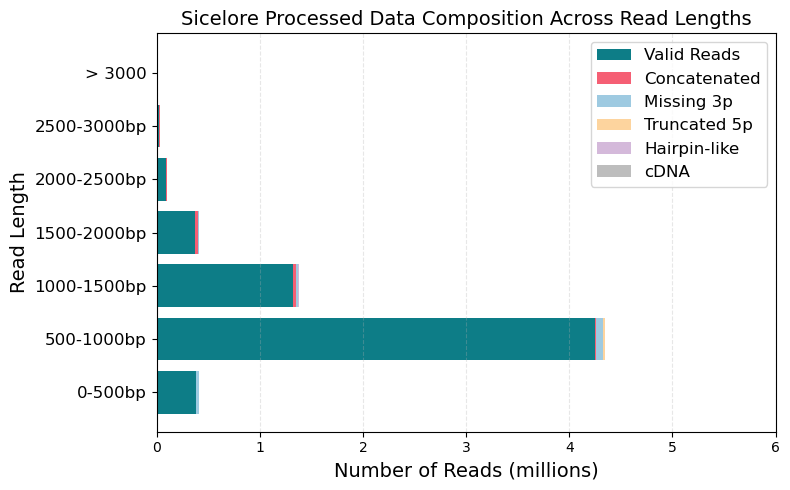

In [25]:
import matplotlib.pyplot as plt

# Convert to pandas
df = major_artifacts_prop_w_bins_df.to_pandas()

# Calculate valid reads
df["valid_reads"] = df["total_reads"] - (
    df["concat_reads"] + df["mi_3p"] + df["trunc_5p"] + df["hp_like"] + df["cDNA"]
)

# Set up components for stacking
bins = df["bin"]
valid = df["valid_reads"]
concat = df["concat_reads"]
mi_3p = df["mi_3p"]
trunc_5p = df["trunc_5p"]
hairpin = df["hp_like"]
cdna = df["cDNA"]

# Plot setup
y_pos = range(len(bins))
bar_width = 0.6
fig, ax = plt.subplots(figsize=(8, 5))


ax.barh(y_pos, valid, color="#0d7d87", label="Valid Reads")          # Soft mint green
ax.barh(y_pos, concat, left=valid, color="#f55f74", label="Concatenated")  # Salmon red
ax.barh(y_pos, mi_3p, left=valid + concat, color="#9ecae1", label="Missing 3p")  # Light blue
ax.barh(y_pos, trunc_5p, left=valid + concat + mi_3p, color="#fdd49e", label="Truncated 5p")  # Peach
ax.barh(y_pos, hairpin, left=valid + concat + mi_3p + trunc_5p, color="#d4b9da", label="Hairpin-like")  # Lavender
ax.barh(y_pos, cdna, left=valid + concat + mi_3p + trunc_5p + hairpin, color="#bdbdbd", label="cDNA")  # Muted gray

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(bins, fontsize=12)
ax.set_xlabel("Number of Reads (millions)", fontsize=14)
ax.set_ylabel("Read Length", fontsize=14)
ax.set_title("Sicelore Processed Data Composition Across Read Lengths", fontsize=14)
ax.legend(loc="upper right", fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.grid(axis='y', linestyle='', alpha=0.3)
ax.set_xlim(0, 6)

plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Sicelore_data_composition_counts.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Sicelore_data_composition_counts.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Sicelore_data_composition_counts.pdf", bbox_inches='tight')

plt.show()

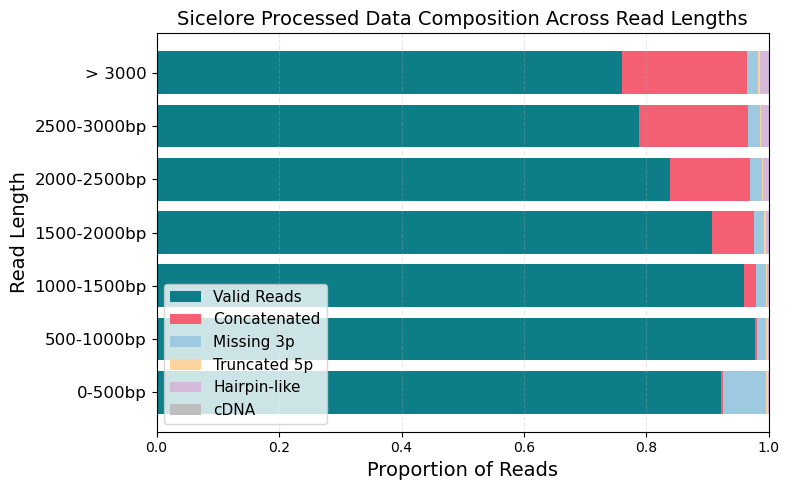

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas
df = major_artifacts_prop_w_bins_df.to_pandas()

# Calculate valid reads
df["valid_reads"] = df["total_reads"] - (
    df["concat_reads"] + df["mi_3p"] + df["trunc_5p"] + df["hp_like"] + df["cDNA"]
)

# Normalize each category by the total reads to get proportions
df["valid_prop"] = df["valid_reads"] / df["total_reads"]
df["concat_prop"] = df["concat_reads"] / df["total_reads"]
df["mi_3p_prop"] = df["mi_3p"] / df["total_reads"]
df["trunc_5p_prop"] = df["trunc_5p"] / df["total_reads"]
df["hairpin_prop"] = df["hp_like"] / df["total_reads"]
df["cdna_prop"] = df["cDNA"] / df["total_reads"]

# Setup for plotting
bins = df["bin"]
valid = df["valid_prop"]
concat = df["concat_prop"]
mi_3p = df["mi_3p_prop"]
trunc_5p = df["trunc_5p_prop"]
hairpin = df["hairpin_prop"]
cdna = df["cdna_prop"]

# Plot setup
y_pos = range(len(bins))
fig, ax = plt.subplots(figsize=(8, 5))

# Stack bar plots
ax.barh(y_pos, valid, color="#0d7d87", label="Valid Reads")
ax.barh(y_pos, concat, left=valid, color="#f55f74", label="Concatenated")
ax.barh(y_pos, mi_3p, left=valid + concat, color="#9ecae1", label="Missing 3p")
ax.barh(y_pos, trunc_5p, left=valid + concat + mi_3p, color="#fdd49e", label="Truncated 5p")
ax.barh(y_pos, hairpin, left=valid + concat + mi_3p + trunc_5p, color="#d4b9da", label="Hairpin-like")
ax.barh(y_pos, cdna, left=valid + concat + mi_3p + trunc_5p + hairpin, color="#bdbdbd", label="cDNA")

# Axis formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(bins, fontsize=12)
ax.set_xlim(0, 1.0)  # proportion range
ax.set_xlabel("Proportion of Reads", fontsize=14)
ax.set_ylabel("Read Length", fontsize=14)
ax.set_title("Sicelore Processed Data Composition Across Read Lengths", fontsize=14)
ax.legend(loc="lower left", fontsize=11, frameon=True)
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Sicelore_data_composition_proportion.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Sicelore_data_composition_proportion.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/Sicelore_data_composition_proportion.pdf", bbox_inches='tight')

plt.show()

In [27]:
## How many reads after alignment are uniquely supplementary in sicelore

tranquillyzer_supp_reads = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/A375_10mil/CRF/aligned_files/tranquillyzer_supp_reads.txt", has_header=False)
sicelore_supp_reads = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/sicelore_final_bam//sicelore_suppl_read_names.txt", has_header=False)

tranq_set = set(tranquillyzer_supp_reads[:, 0])
sicelore_set = set(sicelore_supp_reads[:, 0])


sicelore_only_supp = sicelore_set - tranq_set

print(f'Total Sicelore only supplementary reads: {len(sicelore_only_supp)}')

Total Sicelore only supplementary reads: 145045


In [28]:
# How many of these were concatenated?


print (f'Total Sicelore passed orgnly invalid reads that are still invalid and have produced sppl: {sicelore_passed_tranquillyzer_invalid_invalid_orgnly.filter(pl.col("ReadName").is_in(sicelore_only_supp)).shape[0]}')
print (f'Total Sicelore passed orgnly concat reads that are still invalid and have produced sppl: {sicelore_passed_tranquillyzer_invalid_concat_reads_orgnly.filter(pl.col("ReadName").is_in(sicelore_only_supp)).shape[0]}')
print (f'Total Sicelore passed orgnly concat reads that are still concats and have produced sppl: {sicelore_passed_concat_orgnly_still_concat.filter(pl.col("ReadName").is_in(sicelore_set)).shape[0]}')


sicelore_supp_invalid = sicelore_passed_tranquillyzer_invalid_uq.filter(pl.col("CleanReadName").is_in(tranq_set))
print(f'Total sicelore only supplementary reads that are marked invalid as well: {sicelore_supp_invalid.shape[0]} {sicelore_supp_invalid.shape[0]/len(sicelore_only_supp)}')

sicelore_supp_concat = sicelore_passed_tranquillyzer_invalid_uq.filter(pl.col("CleanReadName").is_in(sicelore_only_supp) & pl.col("reason").str.contains("concatenated reads"))
print(f'Total sicelore only supplementary reads that are concatenated well: {sicelore_supp_concat.shape[0]} {sicelore_supp_concat.shape[0]/len(sicelore_only_supp)}')

sicelore_supp_invalid_orgnly = tranquilizer_A375_CRF_invalid_annots.filter(pl.col("ReadName").is_in(sicelore_only_supp))
print(f'Total sicelore only supplementary reads that were originally marked invalid as well: {sicelore_supp_invalid_orgnly.shape[0]} {sicelore_supp_invalid_orgnly.shape[0]/len(sicelore_only_supp)}')

sicelore_supp_concat_orgnly = tranquilizer_A375_CRF_invalid_annots.filter(pl.col("ReadName").is_in(sicelore_only_supp) & (pl.col("reason").str.contains("concatenated reads")))
print(f'Total sicelore only supplementary reads that were originally concatenated as well: {sicelore_supp_concat_orgnly.shape[0]} {sicelore_supp_concat_orgnly.shape[0]/len(sicelore_only_supp)}')


Total Sicelore passed orgnly invalid reads that are still invalid and have produced sppl: 71792
Total Sicelore passed orgnly concat reads that are still invalid and have produced sppl: 63755
Total Sicelore passed orgnly concat reads that are still concats and have produced sppl: 59153
Total sicelore only supplementary reads that are marked invalid as well: 1025 0.007066772380985211
Total sicelore only supplementary reads that are concatenated well: 59749 0.4119342273087662
Total sicelore only supplementary reads that were originally marked invalid as well: 133038 0.9172187941673274
Total sicelore only supplementary reads that were originally concatenated as well: 119040 0.820710813885346


In [29]:
sicelore_supp_concat_orgnly["read_length"].max()

11187

In [30]:
print(sicelore_supp_invalid_orgnly.filter(pl.col("ReadName").is_in(sicelore_passed_tranquillyzer_valid_uq["CleanReadName"])).group_by("reason").agg(pl.len().alias("count"))\
        .sort("count", descending=True)\
        .with_columns((pl.col("count")/pl.col("count").sum())\
                          .alias("proportion")))

print(','.join(sicelore_passed_tranquillyzer_valid_uq.filter((pl.col("CleanReadName").is_in(sicelore_supp_invalid_orgnly["ReadName"])) & ( pl.col("read_length")> 800))["ReadName"].to_list()[0:20]))

shape: (683, 3)
┌─────────────────────────────────────────────────────────────────────────────┬───────┬────────────┐
│ reason                                                                      ┆ count ┆ proportion │
│ ---                                                                         ┆ ---   ┆ ---        │
│ str                                                                         ┆ u32   ┆ f64        │
╞═════════════════════════════════════════════════════════════════════════════╪═══════╪════════════╡
│ concatenated reads x2 (+:1, -:1)                                            ┆ 19998 ┆ 0.298117   │
│ concatenated reads x2 (+:2)                                                 ┆ 13391 ┆ 0.199624   │
│ concatenated reads x2 (-:2)                                                 ┆ 11773 ┆ 0.175504   │
│ concatenated reads x3 (+:1, -:2)                                            ┆ 4067  ┆ 0.060628   │
│ concatenated reads x3 (+:2, -:1)                                         

In [31]:
## wf-single-cell

wfsc_passed_tranquillyzer_invalid = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/wfsc_passed/annotations_invalid.parquet",
                                                        columns=["ReadName", "read_length", "reason"])
wfsc_passed_tranquillyzer_invalid = wfsc_passed_tranquillyzer_invalid.with_columns(pl.col("ReadName").str.split("_").list.get(0).alias("CleanReadName"))
wfsc_passed_tranquillyzer_invalid_uq = wfsc_passed_tranquillyzer_invalid.unique(maintain_order=True)

wfsc_passed_tranquillyzer_valid = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/wfsc_passed/annotations_valid.parquet",
                                                      columns = ["ReadName", "read_length", "reason"])
wfsc_passed_tranquillyzer_valid = wfsc_passed_tranquillyzer_valid.with_columns(pl.col("ReadName").str.split("_").list.get(0).alias("CleanReadName"))
wfsc_passed_tranquillyzer_valid_uq = wfsc_passed_tranquillyzer_valid.unique(maintain_order=True)

wfsc_total_passed_reads = pl.concat([wfsc_passed_tranquillyzer_invalid_uq, wfsc_passed_tranquillyzer_valid_uq], how="vertical")
wfsc_total_passed_reads_uq = set(wfsc_passed_tranquillyzer_invalid_uq["CleanReadName"].to_list() + wfsc_passed_tranquillyzer_valid_uq["CleanReadName"].to_list())


In [32]:
print(wfsc_passed_tranquillyzer_invalid_uq.shape)
print(wfsc_passed_tranquillyzer_valid_uq.shape)
print(wfsc_total_passed_reads.shape)
print(len(wfsc_total_passed_reads_uq))

(5879825, 4)
(2289, 4)
(5882114, 4)
5711108


In [33]:
wfsc_passed_tranquillyzer_mi_3p = wfsc_passed_tranquillyzer_invalid_uq.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                        .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))
wfsc_passed_tranquillyzer_concat = wfsc_passed_tranquillyzer_invalid_uq.filter((pl.col("reason").str.contains("concatenated reads")))
wfsc_passed_tranquillyzer_hp = wfsc_passed_tranquillyzer_invalid_uq.filter((pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]"))


In [34]:
print(wfsc_passed_tranquillyzer_mi_3p.shape)
print(wfsc_passed_tranquillyzer_concat.shape)

(32014, 4)
(6696, 4)


In [35]:
wfsc_passed_tranquillyzer_invalid_summary = wfsc_passed_tranquillyzer_invalid_uq.filter(pl.col("reason") != "Unexpected pattern: [cDNA]")\
        .group_by("reason").agg(pl.len().alias("count"))\
        .sort("count", descending=True)\
        .with_columns((pl.col("count")/pl.col("count").sum())\
                          .alias("proportion"))

print(wfsc_passed_tranquillyzer_invalid_summary)

print(f'total reads that are still concatenated: {wfsc_passed_tranquillyzer_invalid_summary.filter(pl.col("reason").str.contains("concatenated reads"))["count"].sum()}')
print(f'total reads that are still concatenated: {wfsc_passed_tranquillyzer_invalid_summary.filter(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA_3p_cDNA_polyT_cDNA]")["count"].sum()}')

shape: (948, 3)
┌────────────────────────────────────────────────────────────────────────────┬────────┬────────────┐
│ reason                                                                     ┆ count  ┆ proportion │
│ ---                                                                        ┆ ---    ┆ ---        │
│ str                                                                        ┆ u32    ┆ f64        │
╞════════════════════════════════════════════════════════════════════════════╪════════╪════════════╡
│ Unexpected pattern: [cDNA_polyT_cDNA]                                      ┆ 573220 ┆ 0.57485    │
│ Unexpected pattern: [cDNA_CBC_UMI_polyT_cDNA]                              ┆ 55326  ┆ 0.055483   │
│ Unexpected pattern: [cDNA_polyT]                                           ┆ 46087  ┆ 0.046218   │
│ Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA_3p_cDNA]                   ┆ 44413  ┆ 0.044539   │
│ Unexpected pattern: [cDNA_polyT_UMI]                                     

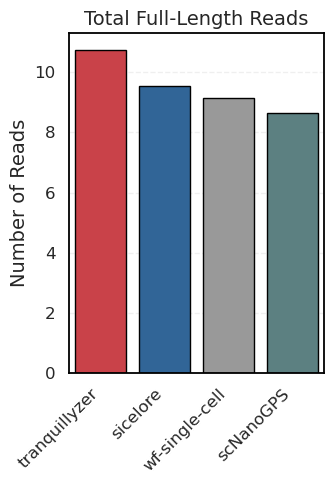

In [36]:
## Total full-length reads from different tools  - plot

full_length_reads = {"tool": ["tranquillyzer", "sicelore", "wf-single-cell", "scNanoGPS"],
                     "reads": [10756514, 9551837, 9131210, 8639762]}
full_length_reads_df = pl.DataFrame(full_length_reads)
full_length_reads_df = full_length_reads_df.with_columns((pl.col("reads")/1000000).alias("reads_in_mil"))

custom_palette = {
    "scNanoGPS": "#568687",
    "tranquillyzer": "#e02b35",  # blue
    "sicelore": "#2066a8",       # orange
    "wf-single-cell": "#999999",      # green (add more if needed)
}

# Plot
plt.figure(figsize=(3.5, 5))
sns.set(style="whitegrid")

# Add border around plot
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.3)

# Create boxplot
# plt.figure(figsize=(3, 5))
ax = sns.barplot(data=full_length_reads_df, 
                 x="tool", y="reads_in_mil", hue="tool",
                 edgecolor="black",
                 palette=custom_palette)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("", fontsize=14)
plt.ylabel("Number of Reads", fontsize=14)
plt.title("Total Full-Length Reads", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/total_reads_recoverable.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/total_reads_recoverable.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/total_reads_recoverable.pdf", bbox_inches='tight')

plt.show()

In [37]:
## Overlapping and non-overlapping Supplementary reads produced by each tool

tranquillyzer_supp_reads = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/A375_10mil/CRF/aligned_files/tranquillyzer_supp_reads.txt", has_header=False)
sicelore_supp_reads = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/sicelore_final_bam//sicelore_suppl_read_names.txt", has_header=False)
wfsc_supp_reads = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/wfsc_passed/wfsc_suppl_read_names.txt", has_header=False)
scNano_supp_reads = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/scNanoGPS_data/scNanoGPS_passed/scNanoGPS_supp_readnames.txt", has_header=False)

In [38]:
## Proportion of supplementary reads

tranq_set = set(tranquillyzer_supp_reads[:, 0])
sicelore_set = set(sicelore_supp_reads[:, 0])
wfsc_set = set(wfsc_supp_reads[:, 0])
scnano_set = set(scNano_supp_reads[:, 0])

def pairwise_compare(set1, set2):
    both = set1 & set2
    only1 = set1 - set2
    only2 = set2 - set1
    return both, only1, only2

supp_reads_prop = {"tool_names": ["tranquillyzer", "sicelore", "wf-single-cell", "scNanoGPS"],
                   "aligned_reads": [5554646, len(sicelore_total_passed_reads_uq), 5882114 , 8639762],
                   "supp_reads": [len(tranquillyzer_supp_reads), len(sicelore_supp_reads),
                                  len(wfsc_supp_reads), len(scNano_supp_reads)]}
supp_reads_prop_df = pl.DataFrame(supp_reads_prop)
supp_reads_prop_df = supp_reads_prop_df.with_columns((pl.col("supp_reads")/pl.col("aligned_reads")).alias("supp_proportion"))
supp_reads_prop_df

tool_names,aligned_reads,supp_reads,supp_proportion
str,i64,i64,f64
"""tranquillyzer""",5554646,245724,0.044238
"""sicelore""",6324715,366251,0.057908
"""wf-single-cell""",5882114,340040,0.057809
"""scNanoGPS""",8639762,892529,0.103305


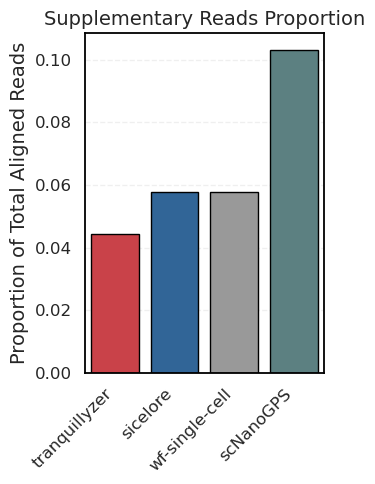

In [39]:
supp_reads_prop_pd = supp_reads_prop_df.to_pandas()

custom_palette = {
    "scNanoGPS": "#568687",
    "tranquillyzer": "#e02b35",  # blue
    "sicelore": "#2066a8",       # orange
    "wf-single-cell": "#999999",      # green (add more if needed)
}

# Plot
plt.figure(figsize=(3.5, 5))
sns.set(style="whitegrid")

# Add border around plot
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.3)

# Create boxplot
# plt.figure(figsize=(3, 5))
ax = sns.barplot(data=supp_reads_prop_pd, 
                 x="tool_names", y="supp_proportion", 
                 hue="tool_names", palette=custom_palette,
                 edgecolor="black")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("", fontsize=14)
plt.ylabel("Proportion of Total Aligned Reads", fontsize=14)
plt.title("Supplementary Reads Proportion", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_proprotion.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_proprotion.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_proprotion.pdf", bbox_inches='tight')

plt.show()

In [40]:
tranq_set = set(tranquillyzer_supp_reads[:, 0])
sicelore_set = set(sicelore_supp_reads[:, 0])
wfsc_set = set(wfsc_supp_reads[:, 0])
scnano_set = set(scNano_supp_reads[:, 0])

tool_sets = [sicelore_set, wfsc_set, scnano_set]
tool_names = ["sicelore", "wf-single-cell", "scNanoGPS"]

def pairwise_compare(set1, set2):
    both = set1 & set2
    only1 = set1 - set2
    only2 = set2 - set1
    return both, only1, only2

supp_reads_summary = {
    "tool": [],
    "unique_supp_reads": [],
    "artifact_proportion": [],
    "concatenated_proportion": []
}

for tool_name, tool_set in zip(tool_names, tool_sets):
    common_reads, tranq_only, tool_only = pairwise_compare(tranq_set, tool_set)

    tool_supp_invalid_orgnly = tranquilizer_A375_CRF_invalid_annots.filter(
        pl.col("ReadName").is_in(tool_only)
    )
    tool_supp_concat_orgnly = tool_supp_invalid_orgnly.filter(
        pl.col("reason").str.contains("concatenated reads")
    )

    supp_reads_summary["tool"].append(tool_name)
    supp_reads_summary["unique_supp_reads"].append(len(tool_only))
    supp_reads_summary["artifact_proportion"].append(
        len(tool_supp_invalid_orgnly) / len(tool_only) if len(tool_only) > 0 else 0
    )
    supp_reads_summary["concatenated_proportion"].append(
        len(tool_supp_concat_orgnly) / len(tool_only) if len(tool_only) > 0 else 0
    )

supp_reads_summary_df = pl.DataFrame(supp_reads_summary)
supp_reads_summary_df

tool,unique_supp_reads,artifact_proportion,concatenated_proportion
str,i64,f64,f64
"""sicelore""",145045,0.917219,0.820711
"""wf-single-cell""",131724,0.875216,0.854757
"""scNanoGPS""",657251,0.905196,0.878293


/tmp/ipykernel_3151683/2195822036.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.012007 0.016437 0.06231 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  bottoms[subset["tool"]] += subset["Read Count"].values


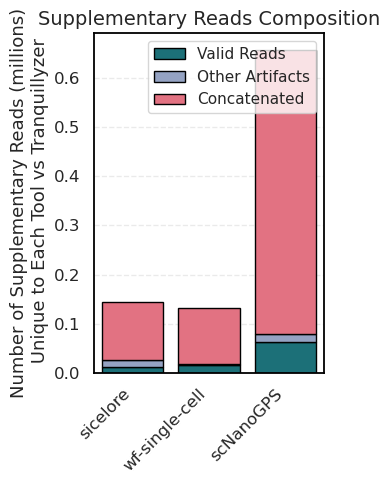

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Convert to pandas
df = supp_reads_summary_df.to_pandas()

# Calculate absolute read counts
df["Concatenated"] = ((df["unique_supp_reads"] * df["concatenated_proportion"]).astype(int))/1000000
df["Other Artifacts"] = ((df["unique_supp_reads"] * df["artifact_proportion"]).astype(int))/1000000 - df["Concatenated"]
df["Valid Reads"] = (df["unique_supp_reads"])/1000000 - df["Concatenated"] - df["Other Artifacts"]

# Melt to long-form
df_melted = df.melt(id_vars=["tool"], 
                    value_vars=["Valid Reads", "Other Artifacts", "Concatenated"], 
                    var_name="Category", 
                    value_name="Read Count")

# Set color palette
palette = {
    "Valid Reads": "#0d7d87",
    "Other Artifacts": "#8da0cb",
    "Concatenated": "#f55f74"
}

# Plot
plt.figure(figsize=(3.5, 5))
sns.set(style="whitegrid")

# Bottom stacking
bottoms = pd.Series([0]*len(df["tool"]), index=df["tool"])
for category in ["Valid Reads", "Other Artifacts", "Concatenated"]:
    subset = df_melted[df_melted["Category"] == category]
    sns.barplot(x="tool", y="Read Count", data=subset, label=category,
                color=palette[category], edgecolor="black", bottom=bottoms[subset["tool"]].values)
    bottoms[subset["tool"]] += subset["Read Count"].values

# Add border around plot
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.3)

# Labels and styling
plt.xlabel("")
plt.ylabel("Number of Supplementary Reads (millions)\n Unique to Each Tool vs Tranquillyzer", fontsize=13)
plt.title("Supplementary Reads Composition", fontsize=14)
plt.legend(title="", fontsize=11)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_composition_counts.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_composition_counts.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_composition_counts.pdf", bbox_inches='tight')

plt.show()

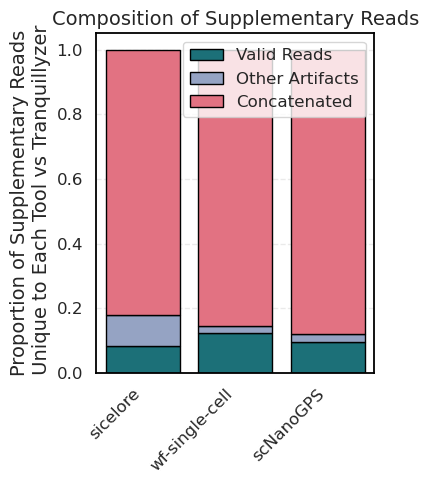

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to pandas
df = supp_reads_summary_df.to_pandas()

# Compute proportions for each category
df["Concatenated"] = df["concatenated_proportion"]
df["Other Artifacts"] = df["artifact_proportion"] - df["concatenated_proportion"]
df["Valid Reads"] = 1 - df["artifact_proportion"]

# Melt to long format
df_melted = df.melt(id_vars=["tool"], 
                    value_vars=["Valid Reads", "Other Artifacts", "Concatenated"], 
                    var_name="Category", 
                    value_name="Proportion")

# Set order for stacking (largest category on bottom)
category_order = ["Valid Reads", "Other Artifacts", "Concatenated"]

# Define color palette
palette = {
    "Valid Reads": "#0d7d87",
    "Other Artifacts": "#8da0cb",
    "Concatenated": "#f55f74"
}


# Initialize the plot
plt.figure(figsize=(4, 5))
sns.set(style="whitegrid")

# Track bottom position manually for stacking
bottoms = pd.Series([0.0]*len(df["tool"]), index=df["tool"])

# Stack each category in order
for category in category_order:
    subset = df_melted[df_melted["Category"] == category]
    sns.barplot(
        x="tool", y="Proportion", data=subset, label=category,
        color=palette[category], edgecolor="black",
        bottom=bottoms[subset["tool"]].values
    )
    bottoms[subset["tool"]] += subset["Proportion"].values

# Set y-axis formatter to scientific with 'e' notation
formatter = ScalarFormatter(useMathText=False)
formatter.set_powerlimits((0, 0))
plt.gca().yaxis.set_major_formatter(formatter)

# Add border around plot
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.3)

# Customize plot
plt.xlabel("")
plt.ylabel("Proportion of Supplementary Reads\n Unique to Each Tool vs Tranquillyzer", fontsize=14)
plt.title("Composition of Supplementary Reads", fontsize=14)
plt.legend(title="", fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()

# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_composition_proprotion.png", dpi=300, bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_composition_proprotion.svg", bbox_inches='tight')
# plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure3/supplementary_reads_composition_proprotion.pdf", bbox_inches='tight')

plt.show()

In [49]:

sicelore_set = set(sicelore_supp_reads[:, 0])
wfsc_set = set(wfsc_supp_reads[:, 0])
scnano_set = set(scNano_supp_reads[:, 0])


tranq_invalid_concat_set = set(
    tranquilizer_A375_CRF_invalid_annots
    .filter(pl.col("reason").str.contains("concatenated reads"))
    ["ReadName"]
    .to_list()
)

common_concat_all_tools = sicelore_set & wfsc_set & scnano_set

final_common_reads = common_concat_all_tools & tranq_invalid_concat_set

print(f"Total reads concatenated in all 3 tools and originally invalid in Tranquilizer: {len(final_common_reads)}")

final_common_reads_list = list(final_common_reads)

print(','.join(final_common_reads_list[0:40]))



Total reads concatenated in all 3 tools and originally invalid in Tranquilizer: 24489
SRR21492159.66358993,SRR21492159.90791441,SRR21492159.84404525,SRR21492159.79453212,SRR21492159.34336113,SRR21492159.36098538,SRR21492159.31276926,SRR21492159.12139638,SRR21492159.23779177,SRR21492159.104370794,SRR21492159.75121059,SRR21492159.71685699,SRR21492159.63493628,SRR21492159.28725358,SRR21492159.73008511,SRR21492159.94410395,SRR21492159.37773286,SRR21492159.69906237,SRR21492159.15493465,SRR21492159.97649744,SRR21492159.83325250,SRR21492159.55361607,SRR21492159.27382453,SRR21492159.59236582,SRR21492159.97446319,SRR21492159.24729055,SRR21492159.48584218,SRR21492159.6913624,SRR21492159.21582512,SRR21492159.31864199,SRR21492159.4999427,SRR21492159.13461260,SRR21492159.89918985,SRR21492159.66728916,SRR21492159.45014956,SRR21492159.72629628,SRR21492159.46742789,SRR21492159.98432487,SRR21492159.11905665,SRR21492159.66995385


In [3]:
tranquilizer_A375_CRF_invalid_annots.filter(pl.col("ReadName") == "SRR21492159.31864199")

ReadName,read_length,reason
str,i64,str
"""SRR21492159.31864199""",2123,"""concatenated reads x2 (+:2)"""


In [43]:
## Read length proportion distribution of Concatenated reads

## Distribution of artifact types across read lengths


major_artifacts_prop_w_bins_df

def artifact_read_length_distr(annots_invalid, annots_valid):
    bins = [(0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),(2500,3000), (3000, " >")]
    major_artifacts_prop_w_bins = []
    
    for bin in bins:
        if bin[1] != " >":
            binned_invalid = annots_invalid.filter(
                (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
            binned_valid = annots_valid.filter(
                (pl.col('read_length') >= bin[0]) & (pl.col('read_length') < bin[1]))
            bin_name = str(bin[0]) + '-' + str(bin[1]) + 'bp'
        else:
            binned_invalid = annots_invalid.filter((pl.col('read_length') >= bin[0]))
            binned_valid = annots_valid.filter(
                (pl.col('read_length') >= bin[0]))
            bin_name = '> ' + str(bin[0]) 
                                                             
        bin_artifacts = binned_invalid.group_by("reason").agg(pl.len().alias("count"))\
            .with_columns((pl.col("count") / pl.col("count").sum()).alias("percentage"))\
                .sort("percentage", descending=True)
    
        total_reads = binned_invalid.shape[0] + binned_valid.shape[0]
        total_artifactual_reads = binned_invalid.shape[0]
        total_artifactual_prop = binned_invalid.shape[0]/(total_reads)

        concat_reads = bin_artifacts.filter(pl.col("reason")\
                                            .str.contains("concatenated reads"))["count"].sum()
        concat_prop = concat_reads/total_reads

        mi_3p = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA]")\
                                    .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                        .or_(pl.col("reason") =="Unexpected pattern: [5p_CBC_UMI_polyT_cDNA]")\
                                            .or_(pl.col("reason") == "Unexpected pattern: [cDNA_polyT_UMI_CBC_5p]"))["count"].sum()
        mi_3p_prop = mi_3p/total_reads

        hp_like = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]")\
                                            .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p_cDNA]")\
                                                .or_(pl.col("reason") == "Unexpected pattern: [5p_CBC_UMI_polyT_cDNA_polyT_UMI_CBC_5p]"))["count"].sum()
        hp_like_prop = hp_like/total_reads

        trunc_5p = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA_3p_cDNA_polyT_UMI_CBC_cDNA]")\
                                        .or_(pl.col("reason") == "Unexpected pattern: [cDNA_CBC_UMI_polyT_cDNA_3p_cDNA]"))["count"].sum()
        trunc_5p_prop = trunc_5p/total_reads

        cDNA = bin_artifacts.filter((pl.col("reason")== "Unexpected pattern: [cDNA]"))["count"].sum()
        cDNA_prop = cDNA/total_reads
    
        major_artifacts_prop_w_bins.append((bin_name, total_reads, total_artifactual_reads, total_artifactual_prop, 
                                            mi_3p, mi_3p_prop, concat_reads, concat_prop, trunc_5p, trunc_5p_prop, 
                                            hp_like, hp_like_prop, cDNA, cDNA_prop))

    major_artifacts_prop_w_bins_df = pl.DataFrame(major_artifacts_prop_w_bins, 
                                                  schema=["bin", "total_reads", "total_artifactual_reads", "total_artifactual_prop", 
                                                          "mi_3p", "mi_3p_prop", "concat_reads", "concat_prop", "trunc_5p", "trunc_5p_prop", 
                                                          "hp_like", "hp_like_prop", "cDNA", "cDNA_prop"], orient="row")
    return major_artifacts_prop_w_bins_df


